#### 라이브러리 불러오기

In [29]:
import os

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt 
import seaborn as sns

In [30]:
import platform
import matplotlib.font_manager as fm

_os_name = platform.system()

# font_path는 사용할 폰트에 따라 변경하면 됨
_font_path = 'c:/Windows/Fonts/malgun.ttf' if _os_name=='Windows' \
    else '/usr/share/fonts/truetype/nanum/NanumGothic.ttf'
_font_family = fm.FontProperties(fname=_font_path).get_name()

# font 설정
plt.rcParams['font.family'] = _font_family

# 폰트캐시까지 삭제 후 한글폰트가 사용될 수 있도록 캐시 삭제
# --> 이렇게 해야 비로소 한글이 표현되는 경우가 많음
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = [_font_family]

_fe = fm.FontEntry(
    fname='/usr/share/fonts/truetype/nanum/NanumGothic.ttf',
    name='NanumGothic'
)
fm.fontManager.ttflist.insert(0, _fe)

#### 데이터 불러오기

In [21]:
_PATH_BASE = os.path.join(os.getcwd(), 'data')
get_path = lambda turbin: os.path.join(_PATH_BASE, f'{turbin}_turbin.csv')
df_data = pd.read_csv(get_path('b'))

#### 데이터 전처리

##### 하루단위가 안되는 앞/뒤 데이터 삭제

In [22]:
df_data = df_data.iloc[2:-4]

# 기존 인덱스 갱신
df_data.reset_index(inplace=True)
df_data.drop('index', axis=1, inplace=True)

# 하는김에 일시데이터를 인덱스로 변경
# 이 작업을 할거면 위 두개 작업은 수행하지 않아도 됨
df_data['TURBINE_TIME'] = pd.to_datetime(df_data['TURBINE_TIME'])
df_data.set_index('TURBINE_TIME', inplace=True)
df_data.index.name='index'  # 굳이 안해도됨

##### 결측치 처리

In [23]:
df_data[df_data < 0].count()
# 풍속과 발전량은 음수가 될 수 없으니 발전량을 기준으로 결측치 처리
# 풍향은 음수가 될 수 있음

WIND_SPEED       9353
WIND_DIR        15108
ACTIVE_POWER     9353
month               0
hour                0
dtype: int64

In [24]:
# 단 위와 같은 경우 발전량이 음수일 때, 풍속이 모두 -1인지 확인 필요
df_data[(df_data['ACTIVE_POWER']==-1) & (df_data['WIND_DIR']==-1)].shape[0]

# 발전량이 음수(-1)일때 풍속이 모두 -1(NaN)임,
# 따라서 발전량이 음수면 풍향/풍속 모두 NaN처리

9353

In [25]:
df_data.loc[df_data['ACTIVE_POWER']==-1, 
    ['WIND_SPEED', 'WIND_DIR', 'ACTIVE_POWER']] = np.nan

In [26]:
df_data.isna().sum()

WIND_SPEED      9353
WIND_DIR        9353
ACTIVE_POWER    9353
month              0
hour               0
dtype: int64

In [27]:
# 시계열성값을 이용한 결측치 처리
df_data = df_data.interpolate()

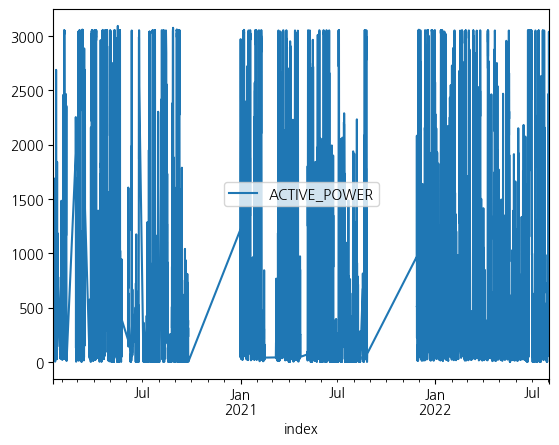

In [34]:
df_data[['ACTIVE_POWER']].plot()
plt.show()

In [35]:
ws = df_data.pop('WIND_SPEED')
wd = df_data.pop('WIND_DIR')
wd_radian = wd * np.pi /180

df_data['ws_X'] = ws * np.cos(wd_radian)
df_data['ws_y'] = ws * np.sin(wd_radian)

In [37]:
df_data.drop(columns=['hour', 'month'], axis=1, inplace=True)

In [39]:
df_data_daily = df_data.resample('D').agg({
    'ACTIVE_POWER': ['mean', 'sum', 'min', 'max'],
    'ws_X': ['mean', 'sum', 'min', 'max'],
    'ws_y': ['mean', 'sum', 'min', 'max'],
})

In [41]:
df_data_daily.columns = [
    f'{col}_{stat}' for col, stat in df_data_daily.columns
]

In [44]:
df_data_daily['day'] = df_data_daily.index.day
df_data_daily['dayofyear'] = df_data_daily.index.dayofyear
df_data_daily['month'] = df_data_daily.index.month

In [45]:
day = 24 * 60 * 60
year = 365.2425 * day
timestampe_s = df_data_daily.index.map(pd.Timestamp.timestamp)

df_data_daily['year_sin'] = np.sin(timestampe_s * (2 * np.pi / year))
df_data_daily['year_cos'] = np.cos(timestampe_s * (2 * np.pi / year))

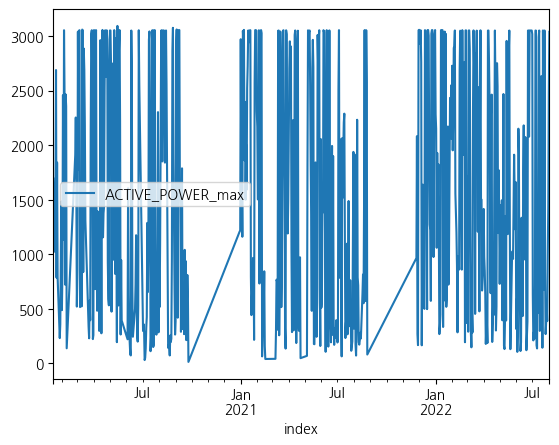

In [50]:
df_data_daily[['ACTIVE_POWER_max']].plot()
plt.show()

In [52]:
df_data_daily['year_sin'].max(), df_data_daily['year_sin'].min()

(0.9999990677453964, -0.9999995213589834)

In [53]:
data_mean, data_std = df_data_daily.mean(), df_data_daily.std()

In [54]:
df_data_daily = (df_data_daily - data_mean) / data_std

In [55]:
df_data_daily.to_csv(os.path.join(_PATH_BASE, 'b_daily.csv'))